In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder

from scipy import stats

sns.set_style("whitegrid")

In [ ]:
df = pd.read_csv('/content/raw.githubusercontent.com_julienjta_Data-Science-Portfolio_main_Project 1_data_dataset.csv',index_col=0)
print(df.shape)
df.head()

In [ ]:
df.isnull().sum()

In [ ]:
df.describe(include='all')

In [ ]:
plt.figure(figsize = (18,5))
plt.subplot(1,2,2)
sns.histplot(x = 'price', data = df, kde = True)
plt.subplot(1,2,1)
sns.boxplot(x = 'price', data = df)

In [ ]:
df['price'].describe()

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(x='airline',
            y='price',
            hue="class",
            data=df.sort_values("price")).set_title('Airline prices based on the class and company',fontsize=12)

In [ ]:
fig, axs = plt.subplots (1, 2, gridspec_kw={'width_ratios': [5, 3]}, figsize=(25, 5))

# Visualization for Economy Class Flights
sns.violinplot(y = "price",
               x = "airline",
               data = df.loc[df["class"]=='Economy'].sort_values("price", ascending = False), kind="boxen", ax=axs[0])
axs[0].set_title("Airline prices based on companies for economy tickets",fontsize=20)

# Visualization for Business Class Flights
sns.violinplot(y = "price",
               x = "airline",
               data = df.loc[df["class"]=='Business'].sort_values("price", ascending = False), kind="boxen", ax=axs[1])
axs[1].set_title("Airline prices based on companies for business tickets",fontsize=20)

In [ ]:
plt.figure(figsize=(12, 5))
# Visualization for All Class Flights
sns.violinplot(y = "price",
               x = "airline",
               data = df.sort_values("price", ascending = False), kind="boxen").set_title("Airline prices based on companies",fontsize=20)

In [ ]:
df_temp = df.groupby(['days_left'])['price'].mean().reset_index()

plt.figure(figsize=(15,6))
ax = sns.scatterplot(x="days_left",
                     y="price", data=df_temp).set_title("Average prices depending on the days left",fontsize=12)

In [ ]:
plt.figure(figsize=(8,5)).suptitle('Airline prices based on days left before buying the ticket', fontsize=16)
ax = plt.axes()

# d-1 departure date
sns.regplot(x=df_temp.loc[df_temp["days_left"]==1].days_left,
            y=df_temp.loc[df_temp["days_left"]==1].price,
            fit_reg=False,
            ax=ax)

# 1-20 days before departure date
sns.regplot(x=df_temp.loc[(df_temp["days_left"]>1)&(df_temp["days_left"]<20)].days_left,
            y=df_temp.loc[(df_temp["days_left"]>1)&(df_temp["days_left"]<20)].price,
            fit_reg=True, ax=ax)

# > 20 days before departure date
sns.regplot(x=df_temp.loc[df_temp["days_left"]>=20].days_left,
            y=df_temp.loc[df_temp["days_left"]>=20].price,
            fit_reg=True, ax=ax)

In [ ]:
df_temp = df.groupby(['duration'])['price'].mean().reset_index()

plt.figure(figsize=(12,5))
ax = sns.scatterplot(x="duration",
                     y="price",
                     data=df_temp).set_title("Average prizes depending on the duration",fontsize=15)

In [ ]:
plt.figure(figsize=(12,5))
ax = sns.regplot(x="duration",
                 y="price",
                 data=df_temp, order=2).set_title("Average prizes depending on the duration",fontsize=15)

In [ ]:
plt.figure(figsize = (15,5))

# Visualization for Departure Time
plt.subplot(1,2,1)
sns.boxplot(data=df,
            y="price",
            x="departure_time",
            showfliers=False).set_title("Airline prices based on the departure time",fontsize=12)

# Visualization for Arrival Time
plt.subplot(1,2,2)
sns.boxplot(data=df,
            y="price",
            x="arrival_time",
            showfliers=False).set_title("Airline prices based on the arrival time",fontsize=12)

In [ ]:
fig, axs = plt.subplots (1, 2, gridspec_kw={'width_ratios': [5, 3]}, figsize=(25, 5))

# Visualization for Economy Class
sns.barplot(y = "price",
            x = "airline",
            hue="stops",
            data = df.loc[df["class"]=='Economy'].sort_values("price", ascending = False), ax=axs[0])
axs[0].set_title("Airline prices based on the number of stops  for economy",fontsize=20)

# Visualization for Business Class
sns.barplot(y = "price",
            x = "airline",
            hue="stops",
            data = df.loc[df["class"]=='Business'].sort_values("price", ascending = False), ax=axs[1])
axs[1].set_title("Airline prices based on the number of stops  for business",fontsize=20)

In [ ]:
def preprocessing(df):
    #Encode the ordinal variables "stops" and "class".
    df["stops"] = df["stops"].replace({'zero':0,'one':1,'two_or_more':2}).astype(int)
    df["class"] = df["class"].replace({'Economy':0,'Business':1}).astype(int)

    #Create the dummy variables for the cities, the times and the airlines.
    dummies_variables = ["airline","source_city","destination_city","departure_time","arrival_time"]
    dummies = pd.get_dummies(df[dummies_variables], drop_first= True)
    df = pd.concat([df,dummies],axis=1)

    #Create the dummy variables for the cities, the times and the airlines.
    df = df.drop(["flight","airline","source_city","destination_city","departure_time","arrival_time"],axis=1)

    return df

In [ ]:
df_preprocessed = preprocessing(df)

In [ ]:
mask = np.triu(np.ones_like(df_preprocessed.corr(), dtype=bool))

plt.figure(figsize = (25, 25))
sns.heatmap(df_preprocessed.corr(), mask=mask,annot = True, vmin= -1.0, vmax= 1.0, center = 0, cmap = 'RdBu_r')

In [ ]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()

    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)

    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [ ]:
X = df_preprocessed.copy()
y = X.pop("price")

mi_scores = make_mi_scores(X, y)

In [ ]:
print(mi_scores.sort_values(ascending=False))

In [ ]:
def load_data():
    # Read data
    df = pd.read_csv("/content/raw.githubusercontent.com_julienjta_Data-Science-Portfolio_main_Project 1_data_dataset.csv",index_col=0)

    # Preprocessing the data
    df = preprocessing(df)

    X = df.copy()
    y = X.pop("price")

    xtrain,xtest,ytrain,ytest = train_test_split(X,y,random_state = 1,test_size=0.3, shuffle=True)

    return xtrain,xtest,ytrain,ytest

In [ ]:
xtrain,xtest,ytrain,ytest = load_data()

In [ ]:
models = {}

models["LinearRegression"]={"model":LinearRegression()}
models["LassoRegression"] = {"model":Lasso()}
models["RidgeRegression"] = {"model":Ridge()}
models["XGBRegressor"]={"model":XGBRegressor(n_jobs=5,learning_rate=0.1,max_depth=10,random_state=1)}
models["XGBRegressor_10"] = {"model": XGBRegressor(n_jobs=5, learning_rate=0.1, max_depth=10, n_estimators=10, random_state=1)}
models["XGBRegressor_50"] = {"model": XGBRegressor(n_jobs=5, learning_rate=0.1, max_depth=10, n_estimators=50, random_state=1)}
models["XGBRegressor_150"] = {"model": XGBRegressor(n_jobs=5, learning_rate=0.1, max_depth=10, n_estimators=150, random_state=1)}

#Tugas yang dimaksud apa seperti ini ya? tolong koreksi jika tidak tepat

In [ ]:
models

{'LinearRegression': {'model': LinearRegression()},
 'LassoRegression': {'model': Lasso()},
 'RidgeRegression': {'model': Ridge()},
 'XGBRegressor': {'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=10, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=5, num_parallel_tree=None, predictor=None,
               random_state=1, ...)},
 'XGBRegressor_5': {'model': XGBRegressor(base_score=None, booster=None, callbacks=None

In [ ]:
def score_dataset(X, y, model=XGBRegressor()):
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes

    score_r2 = cross_val_score(model, X, y, cv=5, scoring="r2")
    score_r2 = score_r2.mean()

    return score_r2

In [ ]:
def get_scores(models,xtrain,ytrain):
  for name,model in models.items():
      model["model"].fit(xtrain,ytrain)

      score_r2 = score_dataset(xtrain, ytrain, model=model["model"])
      score = {'model':"Linear regression", 'score_r2':score_r2}
      print("--- "+name+" ---")
      print("Score r2: {}".format(score_r2))
      print("\n")

In [ ]:
get_scores(models,xtrain,ytrain)

--- LinearRegression ---
Score r2: 0.9095338142489373


--- LassoRegression ---
Score r2: 0.9095311911950965


--- RidgeRegression ---
Score r2: 0.9095338174620945


--- XGBRegressor ---
Score r2: 0.9846636448425355


--- XGBRegressor_5 ---
Score r2: 0.32810950548095086


--- XGBRegressor_10 ---
Score r2: 0.7411893781442787


--- XGBRegressor_150 ---
Score r2: 0.9846636448425355




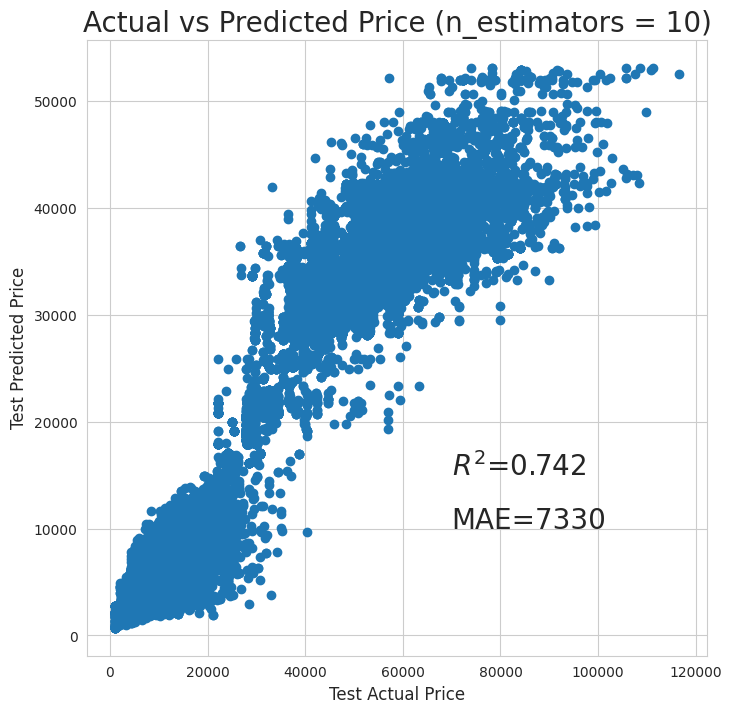

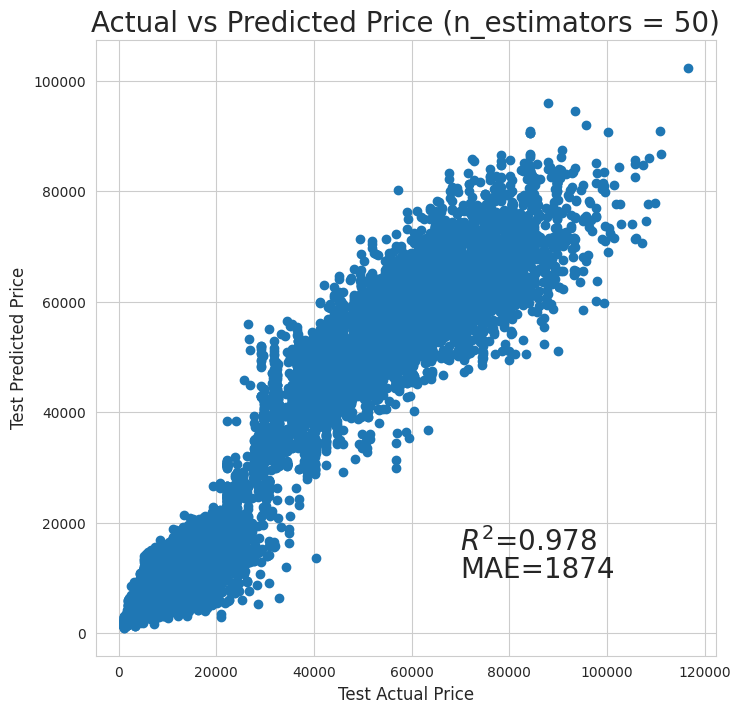

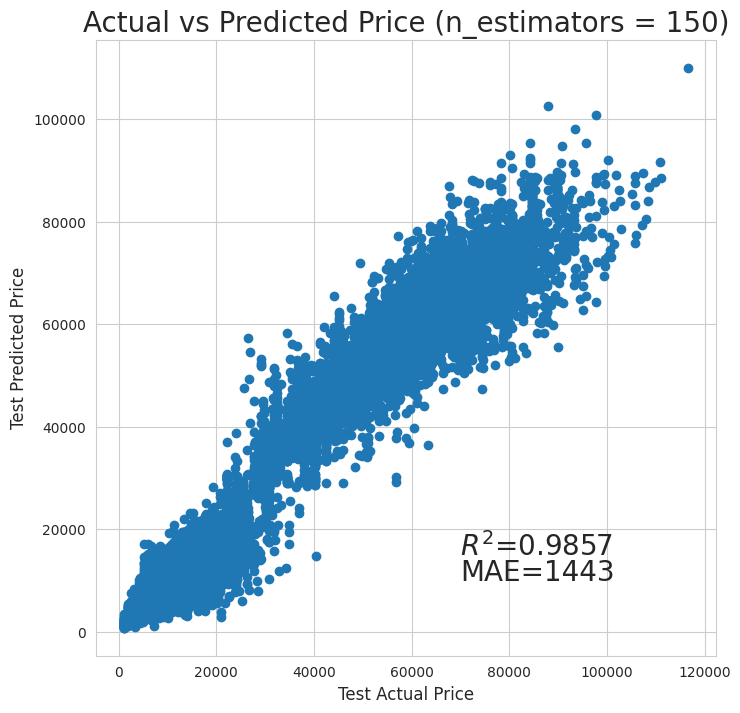

In [ ]:
n_estimators_values = [10, 50, 150]

for n_estimators in n_estimators_values:
    model = models["XGBRegressor"]["model"]
    model.set_params(n_estimators=n_estimators)
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title(f"Actual vs Predicted Price (n_estimators = {n_estimators})", fontsize=20)
    ax.set_ylabel("Test Predicted Price", fontsize=12)
    ax.set_xlabel("Test Actual Price", fontsize=12)
    ax.scatter(ytest, ypred)

    score_r2 = r2_score(ytest, ypred)
    score_mae = mean_absolute_error(ytest, ypred)
    plt.text(70000, 15000, f"$ R^2 $={round(score_r2, 4)}", fontsize=20)
    plt.text(70000, 10000, f"MAE={round(score_mae)}", fontsize=20)
    plt.show()

In [ ]:
# I think it produces different output(r^2) among the n_estimators value because It's simple, more decision trees mean that the model can capture more of the complexity of the data
# the estimator with value = 150 is more better because the R^2 is close to 1, means almost perfect, compared to the others, and the lower MAE score means the accuracy or the model has good predictive power